# Adversarial Attack

In [1]:
from auxiliar_code import *

Using TensorFlow backend.


### Load and show Images

In [2]:
original_image = load_image("water_bottle.jpg")
hacked_image = load_image("hacked_water.png")

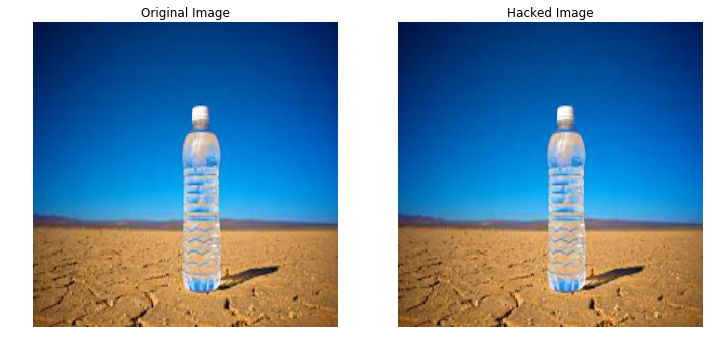

In [3]:
plot_images_contrast(original_image, hacked_image)

### Load Inception Neural Network

In [4]:
nn = load_neural_network("inception")

### Predict

In [5]:
predict(nn, original_image)

water_bottle


In [6]:
predict(nn, hacked_image)

beer_glass


### Explanation

In [8]:
target_class = 441 # Beer Glass Class
# Classes: https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a
im = preprocess_image(original_image)

inp_layer = nn.layers[0].input
out_layer = nn.layers[-1].output

loss = out_layer[0, target_class]
grad = K.gradients(loss, inp_layer)[0]
optimize_gradient = K.function([inp_layer, K.learning_phase()], [grad, loss])
adv = np.copy(im)

In [9]:
cost = 0.0

max_pert = im + 0.01
min_pert = im - 0.01

while cost < 0.95:
    gr, cost = optimize_gradient([adv, 0])
    adv += gr
    adv = np.clip(adv, min_pert, max_pert)
    adv = np.clip(adv, -1 , 1)
    print("Target Cost", cost)

Target Cost 9.625923e-05
Target Cost 9.788232e-05
Target Cost 9.952377e-05
Target Cost 0.000101184385
Target Cost 0.00010290042
Target Cost 0.00010468768
Target Cost 0.000106534404
Target Cost 0.000108424516
Target Cost 0.00011031577
Target Cost 0.0001121936
Target Cost 0.00011408971
Target Cost 0.00011601706
Target Cost 0.000117973046
Target Cost 0.00011998329
Target Cost 0.00012203347
Target Cost 0.00012410339
Target Cost 0.00012624293
Target Cost 0.00012841732
Target Cost 0.00013060005
Target Cost 0.00013279585
Target Cost 0.00013500411
Target Cost 0.00013725764
Target Cost 0.00013959358
Target Cost 0.00014199852
Target Cost 0.00014442405
Target Cost 0.00014683306
Target Cost 0.00014926512
Target Cost 0.00015172697
Target Cost 0.00015421576
Target Cost 0.00015676081
Target Cost 0.0001593352
Target Cost 0.00016196952
Target Cost 0.00016461675
Target Cost 0.00016728645
Target Cost 0.00016997506
Target Cost 0.00017271686
Target Cost 0.00017551755
Target Cost 0.00017835906
Target Cost 0

### Trick Summary

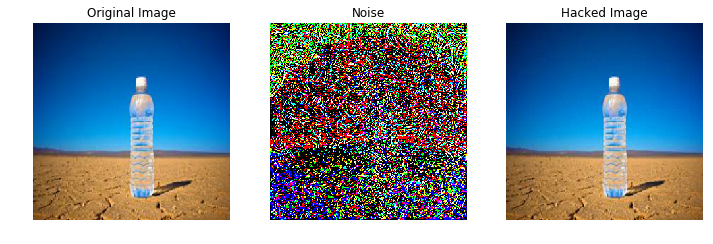

In [11]:
im = denormalise(im.reshape(im.shape[1], im.shape[2], im.shape[3]))
adv = denormalise(adv.reshape(adv.shape[1], adv.shape[2], adv.shape[3]))
plot_images_noise(im, adv)

## Save the Adv Image

In [20]:
# It would be recommended to point the NN hacked
matplotlib.image.imsave('hacked_water_inception.png', adv)

In [ ]:
decode_predictions(nn.predict(adv))